# Notebook to process the raw data
Currently we only look at cargo ship data, but this can be extended to container ships. Additionally, we look at the years 2019 and 2020 only, but this could be extended to quarters.

In [1]:
# in gt env

from os.path import join
import csv
import numpy as np
from numpy.linalg import norm

import scipy.sparse as sp
import scipy.io

import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
from shapely.geometry import LineString

import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length, dijkstra_path
from networkx.convert_matrix import to_numpy_matrix
from networkx.linalg import adjacency_matrix

from tqdm import tqdm


/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# settings
year = 2020
outpath = join("..","data","matrices",f"{year}")
outim = join("..","images","port",f"{year}")
calculate_dists = False
calculate_shotest_paths = False  # not working yet, leave False

# 1. Load the data
- already in alphabetical order
- make dict of names etc.
- to include weightings we look at draught diff? look at this later


In [3]:
OD_ddf = dd.read_csv('../data/raw data/OD_maritime_2019_2020.csv')
OD_length = pd.read_csv('../data/raw data/length_OD.csv')
nodes_gdf = gpd.read_file("../data/raw data/nodes_maritime.gpkg")
edges_gdf = gpd.read_file('../data/raw data/edges_maritime.gpkg')

`set(OD_ddf['sub_vessel_type_AIS'])`

       {'Container', 'General Cargo'}

# 2. Calculate distances based on geo-coordinates

In [4]:
port_ids = {id: port for id, port in zip(nodes_gdf['id'], nodes_gdf['port_country'])}
rport_ids = {port: id for id, port in zip(nodes_gdf['id'], nodes_gdf['port_country'])}
id_df = pd.DataFrame.from_dict(port_ids, orient='index')
id_df.to_csv(outpath + "id_key.csv")
nodes_gdf[["port_country", "x", "y"]].to_csv(outpath + "coords.csv")
N = len(port_ids)

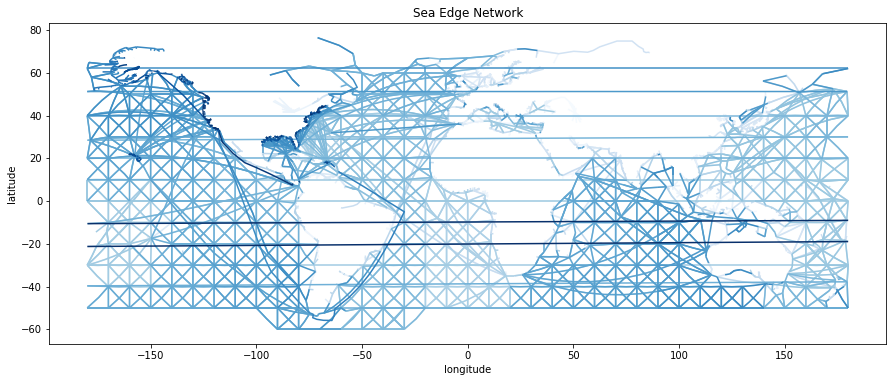

In [5]:
edges_gdf.plot(cmap='Blues', figsize=(15, 20))
plt.title('Sea Edge Network')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.savefig(join(outim,"sea edges.png"), transparent=True)

In [6]:
# undirected graph of sea distances
G_dist = nx.convert_matrix.from_pandas_edgelist(edges_gdf,
                                       source='from_id',
                                       target='to_id',
                                       edge_attr='length_km') #, create_using=nx.DiGraph)

In [7]:
# construct lower triangular sea distance matrix
if calculate_dists:
    N, _ = nodes_gdf.shape
    dmat = [[dijkstra_path_length(G_dist, source=i, target=j, weight='length_km') for j in range(i)] for i in range(N)]

    dmat = np.array([_ + [0]*(N-len(_)) for _ in dmat])
    dmat = dmat + dmat.T
    
    np.save(join("...","data","distances","port_dmat_full"), dmat)

    # not working yet
    if calculate_shortest_paths:
        N, _ = nodes_gdf.shape
        paths = nx.shortest_path(G_dist, weight="length_km")

        test = np.load("../data/port_results/port_shortest_paths.npz", allow_pickle=True)
        test_dict = test['shortest_paths'][()]
        np.savez(join("..","data","distances","port_shortest_paths", shortest_paths=shortest_path_dicts)

In [8]:
dmat = np.load(join("...","data","distances","port_dmat_full"))

plt.figure(figsize=(5,5))
im = plt.imshow(dmat, cmap='Blues_r')
plt.title('Sea Distances')

# save for matlab
scipy.io.savemat(join("..","images","port","port_dmat_full.mat"), mdict={'dmat': dmat})

FileNotFoundError: [Errno 2] No such file or directory: '.../data/distances/port_dmat_full'

In [ ]:
# check all distances agree with OD_length file
incorrect_tuples = []
correct_tuples = []
OD_valid = OD_length[["from_id", "to_id", "length"]]
tol = 1e-6
for i, j, length in OD_valid.itertuples(index=False):
    if abs(D[i, j] - length) > tol:
        print(f"{dmat[i, j]} != {length}")
        incorrect_tuples.append((i, j))
    else:
        correct_tuples.append((i,j))

assert not incorrect_tuples

# 3. Process flow data

### Columns of interest:
`[['vessel_type', 'sub_vessel_type_AIS', 'port_country', 'port_country_B', 'capacity']]` <br>
`vessel types = ['Container', 'General Cargo']`

In [98]:
OD_ddf = dd.read_csv(join('..','data','raw data','OD_maritime_2019_2020.csv'))
col_list = ['vessel_type', 'sub_vessel_type_AIS', 'dwt', 'port_country', 'port_country_B', 'capacity', 'draught_diff']
reduced_col_list = ['port_country', 'port_country_B', 'capacity']

OD_ddf = OD_ddf[OD_ddf.year == year]
OD_ddf = OD_ddf[OD_ddf['sub_vessel_type_AIS'] == 'Container']
OD_ddf = OD_ddf[reduced_col_list]
OD_df = OD_ddf.compute()

In [99]:
trade_intensity = list(OD_df.groupby(["port_country","port_country_B"]).sum('capacity')['capacity'])
flow_counts = list(OD_df.groupby(["port_country","port_country_B"]).size())

OD_df = OD_df[["port_country","port_country_B"]].sort_values(by=["port_country","port_country_B"]).drop_duplicates()
OD_df["flow_counts"] = flow_counts
OD_df["trade_intensity"] = trade_intensity

OD_df["port_country"] = OD_df["port_country"].apply(lambda x: rport_ids[x])
OD_df["port_country_B"] = OD_df["port_country_B"].apply(lambda x: rport_ids[x])
OD_df.columns = ["from_id", "to_id", "flow_counts", "trade_intensity"]
OD_df = OD_df.reset_index(drop=True)

OD_tups = [(i, j) for i, j in zip(OD_df.from_id, OD_df.to_id)]
OD_dict = {tup:count for tup, count in zip(OD_tups, OD_df.flow_counts)}
trade_dict = {tup:count for tup, count in zip(OD_tups, OD_df.trade_intensity)}

fmat = np.zeros([N, N])
for idx, fcount in OD_dict.items():
    fmat[idx[0], idx[1]] = fcount
    
tmat = np.zeros([N, N])
for idx, tcount in trade_dict.items():
    tmat[idx[0], idx[1]] = tcount

In [100]:
# test cell: check fmat entries same as OD_df.flow_counts
incorrect_counts = []
for idx, length in OD_dict.items():
    if fmat[idx[0],idx[1]] != length:
        incorrect_counts.append(idx)
        
assert not incorrect_counts

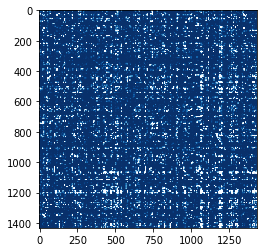

In [101]:
im = plt.imshow(fmat, clim=(0,1), cmap="Blues_r")

In [102]:
sp.save_npz(join(outpath,"unweighted","cargo_ports"), sp.csr_matrix(fmat))
sp.save_npz(join(outpath,"weighted","cargo_ports"), sp.csr_matrix(tmat))


FileNotFoundError: [Errno 2] No such file or directory: '../data/matrices/2020/unweighted/cargo_ports.npz'

In [ ]:
T_flow = sp.load_npz(join(outpath,"unweighted","cargo_ports.npz")).toarray()
T_trade = sp.load_npz(join(outpath,"weighted","cargo_ports.npz")).toarray()

scipy.io.savemat(join(outpath, "unweighted", "cargo_ports.mat"), mdict={'fmat': T_flow})
scipy.io.savemat(join(outpath, "weighted", "cargo_ports.mat"), mdict={'fmat': T_trade})

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
im0 = ax[0].imshow(T_flow, clim=(0, 2), cmap='Blues_r')
ax[0].set_title("Flow adjacency matrix")
ax[0].set_xlabel('node / port')
ax[0].set_ylabel('node / port')

im1 = ax[1].imshow(T_trade, clim=(0, 2000), cmap='Blues_r')
ax[1].set_title("Trade intensity adjacency matrix")
ax[1].set_xlabel('node / port')
ax[1].set_ylabel('node / port')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical', label="flow counts")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label="trade intensity")

xticks = np.arange(0, T_flow.shape[0], 150)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks)
ax[0].set_yticks(xticks[::-1])
ax[0].set_yticklabels(xticks)

ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks)
ax[1].set_yticks(xticks[::-1])
ax[1].set_yticklabels(xticks)

## Deal with isolated ports
The iterative process [chap5] for the doubly-constrained gravity model will not converge if there are nodes with zero in- or out-degree. Thus we will remove them here for the container ship network.

In [ ]:
G_flow = nx.from_numpy_array(T_flow, create_using=nx.DiGraph)
G_trade = nx.from_numpy_array(T_trade, create_using=nx.DiGraph)
isolated = []
isolated_ports = []
for node in G_flow:
    if (G_flow.in_degree[node] == 0.) | (G_flow.out_degree[node] == 0.):
        isolated.append(node)
        isolated_ports.append(port_ids[node])

       
for node in isolated:
    G_flow.remove_node(node)
    G_trade.remove_node(node)
    
portlist = nodes_gdf['port_country'].tolist()

for node in isolated:
    portlist.remove(port_ids[node])
    
port_ids_fconnected = {node: port for node, port in zip(range(len(portlist)), portlist)}
rport_ids_fconnected = {port: node for node, port in port_ids_fconnected.items()}

assert len(rport_ids_fconnected) == G_flow.number_of_nodes()
assert len(rport_ids_fconnected) == G_trade.number_of_nodes()

In [ ]:
T_flow_new = adjacency_matrix(G_flow)
T_trade_new = adjacency_matrix(G_trade)

fig, ax = plt.subplots(1,2)
ax[0].imshow(T_flow_new.todense(), clim=(0,1))
ax[1].imshow(T_trade_new.todense(), clim=(0,1))

In [ ]:
scipy.io.savemat(join(outpath,"unweighted", "cargo_ports.mat"), mdict={'fmat': T_flow_new})
scipy.io.savemat(join(outpath, "weighted", "cargo_ports.mat"), mdict={'fmat': T_trade_new})

sp.save_npz(join(outpath,"unweighted","cargo_ports"), sp.csr_matrix(T_flow_new))
sp.save_npz(join(outpath, "weighted","cargo_ports"), sp.csr_matrix(T_trade_new))

In [ ]:
T_flow_new = sp.load_npz(join(outpath,"unweighted", "cargo_ports.npz"))
T_trade_nw = sp.load_npz(join(outpath, "weighted", "cargo_ports.npz"))

fig, ax = plt.subplots(1,2)
ax[0].imshow(T_flow_new.todense(), clim=(0,1))
ax[1].imshow(T_trade_new.todense(), clim=(0,1))

In [ ]:
id_df_new = pd.DataFrame.from_dict(port_ids_fconnected, orient='index')
id_df_new.to_csv(join(outpath, "id_key.csv"))

In [62]:
# delete I think
coords_new = {}
for idx, row in nodes_gdf.iterrows():
    if row['port_country'] in portlist:
        coords_new[row['port_country']] = (row['x'], row['y'])

## and remove from the distances matrix too

In [89]:
dmat_new = np.delete(dmat, isolated, axis=0)
dmat_new = np.delete(dmat_new, isolated, axis=1)
np.save(join(outpath, "port_dmat"), dmat_new)
scipy.io.savemat(join(outpath,"port_dmat.mat"), mdict={'Dist': dmat_new})

Text(0.5, 1.0, 'Sea Distances')

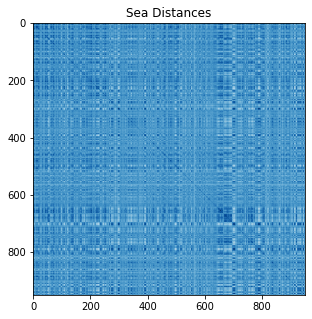

In [68]:
dmat_new = np.load(join(outpath,"port_dmat.npy"))
        
plt.figure(figsize=(5,5))
im = plt.imshow(dmat_new, cmap='Blues_r')
plt.title('Sea Distances')

In [85]:
# new distances check
dmat[1,2]
OD_length_new = OD_length.copy(deep=True)
OD_length_new.from_id = OD_length_new.port_country_O.apply(lambda x: rport_ids_fconnected[x] if x in [*rport_ids_fconnected.keys()] else -1)
OD_length_new.to_id = OD_length_new.port_country_D.apply(lambda x: rport_ids_fconnected[x] if x in [*rport_ids_fconnected.keys()] else -1)
OD_length_new = OD_length_new[OD_length_new.from_id != -1]
OD_length_new = OD_length_new[OD_length_new.to_id != -1]

In [87]:
# check all distances agree with the file Jasper sent me
incorrect_tuples = []
correct_tuples = []
OD_valid = OD_length_new[["from_id", "to_id", "length"]]
tol = 1e-6
for i, j, length in OD_valid.itertuples(index=False):
    if abs(D[i, j] - length) > tol:
        print(f"{dmat[i, j]} != {length}")
        incorrect_tuples.append((i, j))
    else:
        correct_tuples.append((i,j))
        
assert not incorrect_tuples

# Extra things

## Rank-2 SVDs

In [ ]:
# rank-2 SVD approximation
u, s, vh = np.linalg.svd(T_flow, full_matrices=False)
ur = u[:, :r]
sr = s[:r]
vhr = vh[:r, :]
smat = np.diag(sr)
plt.imshow(ur @ smat @ vhr, clim=(0,1))
print(f"rank: {np.linalg.matrix_rank(np.dot(ur, np.dot(smat, vhr)))}")

# rank-2 SVD approximation
u, s, vh = np.linalg.svd(T_trade, full_matrices=False)
ur = u[:, :r]
sr = s[:r]
vhr = vh[:r, :]
smat = np.diag(sr)
plt.imshow(ur @ smat @ vhr, clim=(0,100))
print(f"rank: {np.linalg.matrix_rank(np.dot(ur, np.dot(smat, vhr)))}")

## Get accurate path viz

    # copy me to an implementation cell
    N, _ = nodes_gdf.shape
    paths = {}

    for i in tqdm(range(N)):  # down the
        for j in range(N):  # tiny 
            if nx.has_path(G, source=i, target=j):  # rabbit hole
                paths[(i, j)] = dijkstra_path(G_dist, source=i, target=j, weight='length_km')

    paths_df = pd.DataFrame.from_dict(data=paths, orient='index')
    paths_df = paths_df.aggregate(lambda x: [x.dropna().tolist()], axis=1).map(lambda x:x[0])
    
    coords_df = edges_gdf[['x1', 'y1', 'from_id']]
    coords_df = coords_gdf.drop_duplicates().reset_index(drop=True)
    coords_list = [(x,y) for x, y in zip(coords_df.x1, coords_df.y1)]
    coords_dict = {idx: coords for idx, coords in zip(coords_df.from_id, coords_list)}
    paths_df['coord_path'] = paths_df.path.apply(lambda x: [coords_dict[i] for i in eval(x)])

    paths_df.to_csv(os.path.join(outpath, "shortest_paths.csv"))
    

In [65]:
# implementation cell for later

In [114]:
paths_df = pd.read_csv(os.path.join(outpath, "shortest_paths_geom.csv"))
paths_df.columns = ["edge", "path", "coord_path"]
paths_df.head()

,Unnamed: 0,path,coord_path
0,"(0, 0)",[0.0],"[(148.07756959259032, -19.893776402114334)]"
1,"(1, 1)",[1.0],"[(9.428190685624827, 55.04248019430548)]"
2,"(2, 2)",[2.0],"[(-123.84774329882298, 46.966177639436204)]"
3,"(3, 3)",[3.0],"[(-2.075624103763057, 57.139595144564296)]"
4,"(4, 4)",[4.0],"[(-4.010668932441103, 5.284627760305776)]"


In [120]:
# only take paths of length > 1
paths_gdf = paths_df[paths_df.coord_path.apply(lambda x: len(eval(x)) > 1)].reset_index(drop=True)

# now convert to shapely LineStrings
paths_gdf['coords_geom'] = paths_gdf.coord_path.apply(lambda x: LineString(eval(x)))

# drop path ids column
paths_gdf = paths_gdf[['edge', 'coords_geom']]
paths_gdf = gpd.GeoDataFrame(paths_gdf, geometry=paths_gdf.coords_geom)

# save to new gdf
paths_gdf.to_file(os.path.join(outpath, "shortest_paths_geom.gpkg"), driver="GPKG")

ValueError: Invalid field type <class 'shapely.geometry.linestring.LineString'>

In [121]:
paths_gdf.to_csv(os.path.join(outpath, "shortest_paths_geom.gpkg"))

<AxesSubplot:>

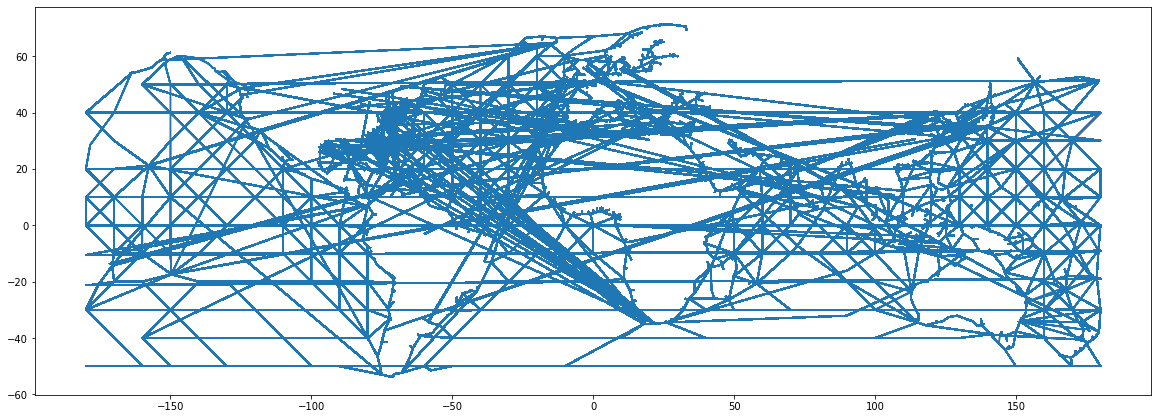

In [125]:
paths_gdf.plot(figsize=(20, 10))

<AxesSubplot:>

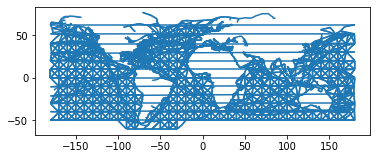

In [123]:
edges_gdf.plot()

<AxesSubplot:>

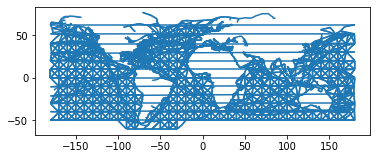

In [61]:
edges_gdf.plot()

<AxesSubplot:>

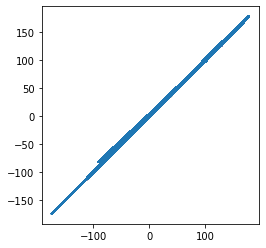

In [59]:
paths_gdf.plot()

In [38]:
edges_gdf.head(3)

,x1,y1,x2,y2,length_haversin,length_km,from_id,from_infra,to_id,to_infra,geometry
0,148.077570,-19.893776,147.100006,-18.70002,167.763636,177.953192,0,port,2615,maritime,"LINESTRING (148.07757 -19.89378, 147.10001 -18..."
1,146.836418,-19.256495,147.100006,-18.70002,67.801103,71.779160,1315,port,2615,maritime,"LINESTRING (146.83642 -19.25650, 147.10001 -18..."
2,146.000000,-16.699989,147.100006,-18.70002,251.067650,263.855142,2276,maritime,2615,maritime,"LINESTRING (146.00000 -16.69999, 147.10001 -18..."


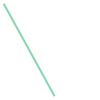

In [51]:
edges_gdf.geometry[2]

In [54]:
print(paths_gdf[paths_gdf.edge=='(4, 5)'].geometry[0])

LINESTRING (-4.010668932441103 -3.999989986, 79.83999428435042 79.51860809, 54.53888689838504 54.07493973)


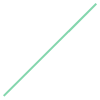

In [57]:
paths_gdf.geometry[0]